In [1]:
import yaml
import torch
import torch.onnx
import numpy as np
import backbone as bb
import onnx
import onnxruntime
import imp
import time
import vis_utils as vu

In [30]:
import efficientdet.utils as eff_utils
imp.reload(eff_utils)
imp.reload(bb)
project_name = "coco"
compound_coef = 0
input_size = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
sample_batch_size = 1
device = torch.device("cpu")
onnx_name = "onnx_efficientdet_d%d.onnx" % compound_coef

In [31]:
params = yaml.safe_load(open(f'parameter/{project_name}.yml'))
obj_list = params['obj_list']    
weights_path = 'checkpoints/efficientdet-d%d.pth' % 0

model = bb.EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),
                             ratios=eval(params['anchors_ratios']), 
                             scales=eval(params['anchors_scales']),
                             onnx_export=True).to(device)

model.backbone_net.model.set_swish(memory_efficient=False)
model.load_state_dict(torch.load(weights_path))  # , map_location=torch.device('cpu')))
model.requires_grad_(False)
model.eval()

EfficientDetBackbone(
  (regressboxes): BBoxTransform()
  (clipboxes): ClipBoxes()
  (bifpn): Sequential(
    (0): BiFPN(
      (conv6_up): SeparableConvBlock(
        (depthwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
        )
        (pointwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
      (conv5_up): SeparableConvBlock(
        (depthwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
        )
        (pointwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
      (conv4_up): SeparableConvBlo

In [4]:
dummy_input = torch.randn((sample_batch_size, 3, input_size[compound_coef], input_size[compound_coef]), 
                          dtype=torch.float32).to(device)

# opset_version can be changed to 10 or other number, based on your need
torch.onnx.export(model, dummy_input,
                  onnx_name,
                  verbose=False,
                  opset_version=11,
                  input_names = ['input'],  
                  output_names = ['output'])

/project/bo/efficient_traffic_count_on_edge_devices/efficientnet/utils_extra.py:34: TracerWarning: Converting a tensor to a NumPy array might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  h, w = x.cpu().detach().numpy().shape[-2:]
/project/bo/efficient_traffic_count_on_edge_devices/efficientnet/utils_extra.py:77: TracerWarning: Converting a tensor to a NumPy array might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  h, w = x.cpu().detach().numpy().shape[-2:]
/project/bo/efficient_traffic_count_on_edge_devices/efficientdet/utils.py:111: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python value

KeyboardInterrupt: 

(5, 6)
inference time 3.439614699227742


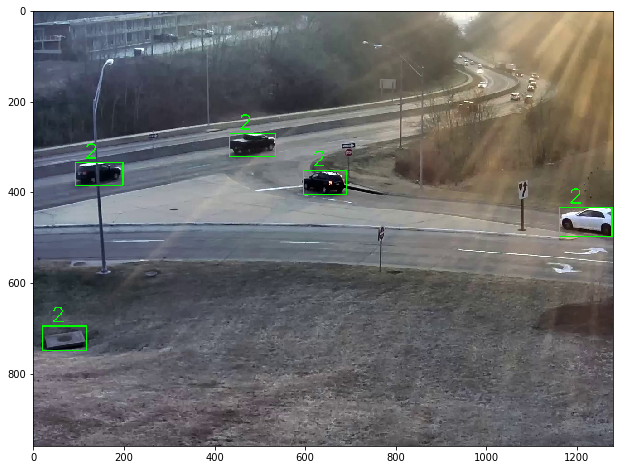

In [23]:
import onnx
model_onnx = onnx.load(onnx_name)
# Check that the IR is well formed
onnx.checker.check_model(model_onnx)
# Print a human readable representation of the graph


import onnxruntime
dummy_input = torch.randn((sample_batch_size, 3, input_size[compound_coef], input_size[compound_coef]), 
                          dtype=torch.float32, requires_grad=True).to(device)
ort_session = onnxruntime.InferenceSession(onnx_name)
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

###########################################################
# check the model output given an image, sucess           #
###########################################################

import utils.utils as input_utils
import vis_utils as vu
import time
img_path = "/project_scratch/bo/normal_data/aic2020/AIC20_track1/Dataset_A_Frame/cam_1_dawn/frame_00000304.jpg"
# img_path = "frames/clip/frame_00000020.jpg"
time_init = time.time()


ori_imgs, framed_imgs, \
    framed_metas = input_utils.preprocess(img_path, max_size=input_size[compound_coef])
x = torch.from_numpy(framed_imgs[0]).to(device).unsqueeze(0).permute(0, 3, 1, 2)

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)[0]
regression = ort_outs[:, :, :4]
classification = ort_outs[:, :, 4:-4]
anchors = ort_outs[:, :, -4:]
# regression, classification, anchors = ort_outs

threshold = 0.3
nms_threshold = 0.4
preds = input_utils.postprocess_npy(anchors, regression, classification, threshold, nms_threshold)
preds = input_utils.invert_affine_npy(framed_metas, preds)[0]
print("inference time", 1/(time.time() - time_init))

vu.show_bbox(ori_imgs[0], preds[:, :4], preds[:, 4], "pred", show=True)


In [33]:
sample_batch_size = 1
dummy_input = torch.randn((sample_batch_size, 3, input_size[compound_coef], input_size[compound_coef]))
traced_model = torch.jit.trace(model, dummy_input)

inference time 2.43123534205825


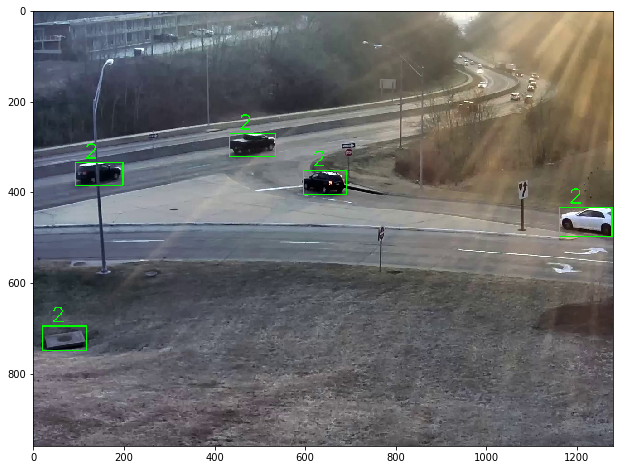

In [34]:
import utils.utils as input_utils
imp.reload(input_utils)
img_path = "/project_scratch/bo/normal_data/aic2020/AIC20_track1/Dataset_A_Frame/cam_1_dawn/frame_00000304.jpg"
# img_path = "frames/clip/frame_00000020.jpg"
time_init = time.time()


ori_imgs, framed_imgs, \
    framed_metas = input_utils.preprocess(img_path, max_size=input_size[compound_coef])
x = torch.from_numpy(framed_imgs[0]).to(device).unsqueeze(0).permute(0, 3, 1, 2)
trace_output = traced_model(x)
regression = trace_output[:, :, :4]
classification = trace_output[:, :, 4:-4]
anchors = trace_output[:, :, -4:]


threshold = 0.3
nms_threshold = 0.4
preds = input_utils.postprocess(anchors, regression, classification, threshold, nms_threshold)
preds = input_utils.invert_affine(framed_metas, preds)[0]
print("inference time", 1/(time.time() - time_init))


vu.show_bbox(ori_imgs[0], preds["rois"], preds["class_ids"], "pred", show=True)


In [35]:
import coremltools as ct

In [36]:
from coremltools.converters.mil.mil import Builder as mb
from coremltools.converters.mil.frontend.torch.torch_op_registry import register_torch_op
from coremltools.converters.mil.frontend.torch.ops import _get_inputs


In [37]:
@register_torch_op(override=True)
def constant_pad_nd(context, node):
    inputs = _get_inputs(context, node, expected=3)
    # print(inputs[1].val, inputs[0].shape)
    new_pad = inputs[1].val.reshape((-1, 2))[::-1].reshape(-1).tolist()
    new_pad = [0]*(2*len(inputs[0].shape)-len(new_pad)) + new_pad
#     print(new_pad, inputs[0].shape)
    padded = mb.pad(x=inputs[0], pad=np.array(new_pad), mode="constant", constant_val=float(0), name=node.name)
    context.add(padded)

In [38]:
@register_torch_op(override=True)
def select(context, node):
    inputs = _get_inputs(context, node, expected=3)
    _input = inputs[0]
    dim = inputs[1].val
    index = inputs[2].val
#     print("Converting op {} : {}".format(node.name, node.kind), _input.shape, _input.val, _input.shape,
#           inputs)

    assert dim.shape == ()
    assert index.shape == ()
#     assert _input.val is None

    # NOTE:
    # Each index in @begin_array/@end_array corresponds to a dimension of @_input
    # Each val of those arrays corresponds to the start/end index to slice in that dimension
    begin_array = [0] * len(_input.shape)
    begin_array[dim] = index
    end_array = [s if isinstance(s, int) else 0 for s in _input.shape]
    end_mask = [True] * len(_input.shape)
    if index != -1:
        end_array[dim] = index + 1
        end_mask[dim] = False

    slice_by_index = mb.slice_by_index(
        x=_input,
        begin=begin_array,
        end=end_array,
        end_mask=end_mask,
        name=node.name + "_slice_by_index",
    )
    # Now we squeeze the dimension we have selected from to remove it
    squeeze = mb.squeeze(
        x=slice_by_index, axes=np.array([dim]), name=node.name + "_squeeze"
    )
    context.add(squeeze, node.name)


In [39]:
@register_torch_op(override=True)
def clamp(context, node):
    inputs = _get_inputs(context, node, expected=3)
    context.add(mb.clip(x=inputs[0], alpha=inputs[1], beta=inputs[2], name=node.name))

In [40]:
ml_dummy = ct.TensorType(name='input', shape=dummy_input.shape)
model_ml = ct.convert(traced_model, inputs=[ml_dummy])

Converting Frontend ==> MIL Ops:  98%|█████████▊| 6971/7095 [00:55<00:01, 68.76 ops/s] 

10741 clamp [<coremltools.converters.mil.mil.var.Var object at 0x7faed5250f30>, <coremltools.converters.mil.mil.var.Var object at 0x7faed5250fa0>, <coremltools.converters.mil.mil.var.Var object at 0x7faed4e38130>] ['10738', '10739', '10740'] [<coremltools.converters.mil.mil.var.Var object at 0x7faed5250f30>, <coremltools.converters.mil.mil.var.Var object at 0x7faed5250fa0>, <coremltools.converters.mil.mil.var.Var object at 0x7faed4e38130>]


Converting Frontend ==> MIL Ops:  99%|█████████▉| 7007/7095 [00:56<00:01, 71.41 ops/s]

10780 clamp [<coremltools.converters.mil.mil.var.Var object at 0x7fae637fb0c0>, <coremltools.converters.mil.mil.var.Var object at 0x7fae637fb130>, <coremltools.converters.mil.mil.var.Var object at 0x7fae637fb280>] ['10777', '10778', '10779'] [<coremltools.converters.mil.mil.var.Var object at 0x7fae637fb0c0>, <coremltools.converters.mil.mil.var.Var object at 0x7fae637fb130>, <coremltools.converters.mil.mil.var.Var object at 0x7fae637fb280>]


Converting Frontend ==> MIL Ops:  99%|█████████▉| 7042/7095 [00:56<00:00, 69.45 ops/s]

10819 clamp [<coremltools.converters.mil.mil.var.Var object at 0x7fae637f4210>, <coremltools.converters.mil.mil.var.Var object at 0x7fae637f4280>, <coremltools.converters.mil.mil.var.Var object at 0x7fae637f43d0>] ['10816', '10817', '10818'] [<coremltools.converters.mil.mil.var.Var object at 0x7fae637f4210>, <coremltools.converters.mil.mil.var.Var object at 0x7fae637f4280>, <coremltools.converters.mil.mil.var.Var object at 0x7fae637f43d0>]


Converting Frontend ==> MIL Ops: 100%|█████████▉| 7079/7095 [00:57<00:00, 72.10 ops/s]

10858 clamp [<coremltools.converters.mil.mil.var.Var object at 0x7faed4df2360>, <coremltools.converters.mil.mil.var.Var object at 0x7faed4df23d0>, <coremltools.converters.mil.mil.var.Var object at 0x7faed4df2520>] ['10855', '10856', '10857'] [<coremltools.converters.mil.mil.var.Var object at 0x7faed4df2360>, <coremltools.converters.mil.mil.var.Var object at 0x7faed4df23d0>, <coremltools.converters.mil.mil.var.Var object at 0x7faed4df2520>]


Translating MIL ==> MLModel Ops: 100%|██████████| 3676/3676 [00:01<00:00, 2317.88 ops/s]


In [42]:
model_ml.save("coreml_efficientdet-d0.mlmodel")

In [41]:
imp.reload(input_utils)
img_path = "/project_scratch/bo/normal_data/aic2020/AIC20_track1/Dataset_A_Frame/cam_1_dawn/frame_00000304.jpg"
# img_path = "frames/clip/frame_00000020.jpg"
time_init = time.time()


ori_imgs, framed_imgs, \
    framed_metas = input_utils.preprocess(img_path, max_size=input_size[compound_coef])
x_npy = np.transpose(np.expand_dims(framed_imgs[0], 0), (0, 3, 1, 2)).astype('float32')
ml_output = model_ml.predict({"input": x_npy})

Exception: Model prediction is only supported on macOS version 10.13 or later.

In [5]:
###########################################################
# convert the onnx model to coreml for iphone             #
###########################################################
import coremltools as ct
from onnx_coreml import convert
import onnx

compound_coef = 0
onnx_name = "onnx_efficientdet_d%d.onnx" % compound_coef
model_onnx = onnx.load(onnx_name)
# model_file = open(onnx_name, 'rb')
# model_proto = onnx.onnx_pb.ModelProto()
# model_proto.ParseFromString(model_file.read())

In [11]:
coreml_model = convert(model_onnx, image_input_names=['input'], image_output_names=['output'],
                       minimum_ios_deployment_target="13",
                      add_custom_layers=True,
                           custom_conversion_functions={'Range':func_range})

NotImplementedError: Unsupported ONNX ops of type: Range,ScatterND 

In [10]:
model_coreml = convert(model_onnx, image_input_names=['input'], minimum_ios_deployment_target="13")

NotImplementedError: Unsupported ONNX ops of type: ATen 

In [5]:
import coremltools

model_ml = coremltools.converters.onnx.convert(model_onnx, image_input_names=["input"], minimum_ios_deployment_target="13")

NotImplementedError: Unsupported ONNX ops of type: ATen 

In [3]:
mlname = "coreml_efficientdet_d%d.mlmodel" % compound_coef
from onnx_coreml import convert
model_ml = convert(model=onnx_name, target_ios="12",)

ModuleNotFoundError: No module named 'coremltools.converters.nnssa'

In [ ]:

model_ml.save(mlname)

In [ ]:
ct.converters.onn